# <center>Временные ряды. <br> Неделя 1

<center> Глазунов А.В.

Задание выполняется в `Google Colab`. Сначала смонтируем `Google Disk` как рабочую директорию. Затем перейдем в папку с данными.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [2]:
cd /content/gdrive/'My Drive'/Colab_Notebooks/ML_c6_TAXI


/content/gdrive/My Drive/Colab_Notebooks/ML_c6_TAXI


In [0]:
PATH_TO_DATA = 'week1'

In [0]:
import os
import pandas as pd
import numpy as np
from scipy import stats
from tqdm import tqdm_notebook
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

Загрузим данные

In [5]:
%%time
df = pd.read_csv(os.path.join(PATH_TO_DATA,'yellow_tripdata_2016-05.csv'))
df.head()

CPU times: user 26.9 s, sys: 3.14 s, total: 30.1 s
Wall time: 33.4 s


In [97]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1,2016-05-01 00:00:00,2016-05-01 00:17:31,1,3.60,-73.985901,40.768040,1,N,-73.983986,40.730099,1,15.0,0.5,0.5,1.50,0.0,0.3,17.80
1,2,2016-05-01 00:00:00,2016-05-01 00:07:31,1,1.68,-73.991577,40.744751,1,N,-73.975700,40.765469,1,7.5,0.5,0.5,0.88,0.0,0.3,9.68
2,2,2016-05-01 00:00:00,2016-05-01 00:07:01,6,1.09,-73.993073,40.741573,1,N,-73.980995,40.744633,1,6.5,0.5,0.5,1.56,0.0,0.3,9.36
3,2,2016-05-01 00:00:00,2016-05-01 00:19:47,1,4.21,-73.991943,40.684601,1,N,-74.002258,40.733002,1,17.0,0.5,0.5,3.66,0.0,0.3,21.96
4,2,2016-05-01 00:00:00,2016-05-01 00:06:39,1,0.56,-74.005280,40.740192,1,N,-73.997498,40.737564,1,6.0,0.5,0.5,1.46,0.0,0.3,8.76


In [6]:
regions = pd.read_csv(os.path.join(PATH_TO_DATA,'regions.csv'),sep=';')
regions.head()

,region,west,east,south,north
0,1,-74.25559,-74.244478,40.496120,40.504508
1,2,-74.25559,-74.244478,40.504508,40.512896
2,3,-74.25559,-74.244478,40.512896,40.521285
3,4,-74.25559,-74.244478,40.521285,40.529673
4,5,-74.25559,-74.244478,40.529673,40.538061


Агрегируем данные

In [0]:
def prepare_dataset_geo_time_series(taxi_data,reg_data):

  """  
  Описание

  Данная функция принимает на вход загруженные 
  таблицу с поездками и список зон с координатами

  Возвращает временной ряд частот поездок по времени 
  размера (time_length х regions_length)

  """
  df = taxi_data.copy()
  regions = reg_data.copy()

  #границы города, y - широта, x - долгота
  (Ymin,Ymax) = (regions.south.min(),regions.north.max())
  (Xmin,Xmax) = (regions.west.min(), regions.east.max())

  #очистка 
  df.drop(df[df.pickup_latitude <= Ymin].index,inplace =True )
  df.drop(df[df.pickup_latitude >= Ymax].index,inplace =True )
  df.drop(df[df.pickup_longitude <= Xmin].index,inplace =True )
  df.drop(df[df.pickup_longitude >= Xmax].index,inplace =True )
  df.drop(df[df.passenger_count == 0].index,inplace =True)
  df.drop(df[df.trip_distance == 0].index,inplace =True)
  df.drop(df[df.tpep_pickup_datetime == df.tpep_dropoff_datetime].index,inplace =True)

  #столбец времени по часам для построения ряда по часам
  df['time'] = df.tpep_pickup_datetime.apply(lambda x: x[:-6])

  #построение таблицы со строками - часами, стобцами - зонами, 
  #на пересечении - количество поездок в данный час из данной зоны
  binx = sorted(list(regions.west.unique()) + [regions.east.max()])
  biny = sorted(list(regions.south.unique()) + [regions.north.max()])

  hour_counts = []
  time = []
  for (tt,sub_df) in tqdm_notebook(df.groupby('time')):
    x = sub_df.pickup_longitude
    y = sub_df.pickup_latitude

    res = stats.binned_statistic_2d(x,y,x, statistic = 'count', bins = [binx,biny])
    counts = res.statistic.reshape(-1)

    time.append(pd.to_datetime(tt))
    hour_counts.append(counts)
  
  #датафрейм-результат, отсортированный по времени в формате datetime
  
  time_series = pd.DataFrame(hour_counts,index = time,columns = list(regions.region),dtype=int)
  time_series.sort_index(inplace=True)

  return time_series
  

Применим функцию и посмотрим на получившуюся матрицу

In [86]:
%time
time_series_table = prepare_dataset_geo_time_series(df,regions)
time_series_table.head(10)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 10 µs


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,2461,2462,2463,2464,2465,2466,2467,2468,2469,2470,2471,2472,2473,2474,2475,2476,2477,2478,2479,2480,2481,2482,2483,2484,2485,2486,2487,2488,2489,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
2016-05-01 00:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-05-01 01:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-05-01 02:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-05-01 03:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-05-01 04:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-05-01 05:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-05-01 06:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-05-01 07:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-05-01 08:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-05-01 09:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [87]:
time_series_table.describe()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,2461,2462,2463,2464,2465,2466,2467,2468,2469,2470,2471,2472,2473,2474,2475,2476,2477,2478,2479,2480,2481,2482,2483,2484,2485,2486,2487,2488,2489,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
count,744.0,744.0,744.0,744.0,744.0,744.0,744.0,744.0,744.0,744.0,744.0,744.0,744.0,744.0,744.000000,744.000000,744.0,744.0,744.0,744.0,744.0,744.0,744.0,744.0,744.000000,744.0,744.000000,744.0,744.0,744.0,744.0,744.000000,744.0,744.0,744.0,744.0,744.0,744.0,744.0,744.0,...,744.0,744.0,744.0,744.0,744.0,744.000000,744.000000,744.000000,744.0,744.000000,744.0,744.000000,744.000000,744.000000,744.0,744.000000,744.0,744.000000,744.000000,744.0,744.000000,744.000000,744.000000,744.000000,744.000000,744.000000,744.000000,744.0,744.0,744.0,744.0,744.0,744.0,744.0,744.0,744.0,744.0,744.0,744.0,744.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001344,0.001344,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001344,0.0,0.001344,0.0,0.0,0.0,0.0,0.025538,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.001344,0.002688,0.001344,0.0,0.002688,0.0,0.005376,0.010753,0.001344,0.0,0.002688,0.0,0.005376,0.005376,0.0,0.010753,0.006720,0.002688,0.001344,0.002688,0.004032,0.004032,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.036662,0.036662,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.036662,0.0,0.036662,0.0,0.0,0.0,0.0,0.221687,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.036662,0.051813,0.036662,0.0,0.051813,0.0,0.089702,0.136846,0.036662,0.0,0.051813,0.0,0.073175,0.073175,0.0,0.171738,0.081757,0.051813,0.036662,0.051813,0.063415,0.081934,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,1.000000,0.0,0.0,0.0,0.0,3.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000,1.000000,0.0,1.000000,0.0,2.000000,3.000000,1.000000,0.0,1.000000,0.0,1.000000,1.000000,0.0,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Количество ячеек в матрице

In [88]:
744*2500

1860000

Размер (количество поездок) исходного и очищенного датасета

In [89]:
df.shape[0],np.sum(time_series_table.values)

(11836853, 11626521)

Подсчитаем долю нулевых ячеек, то есть пар час-зона, в которых не было ни одной поездки в мае 2016 г.

In [90]:
np.sum((time_series_table>0).values)

141762

График количества поездок из ячейки с Empire State Building (40.748817, -73.985428) за май 2016 г.

In [0]:
ESB_lat = 40.748817
ESB_long = -73.985428

In [92]:
regions[regions.south<ESB_lat][regions.north>ESB_lat][regions.west < ESB_long][regions.east > ESB_long]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,region,west,east,south,north
1230,1231,-73.988912,-73.9778,40.747766,40.756154


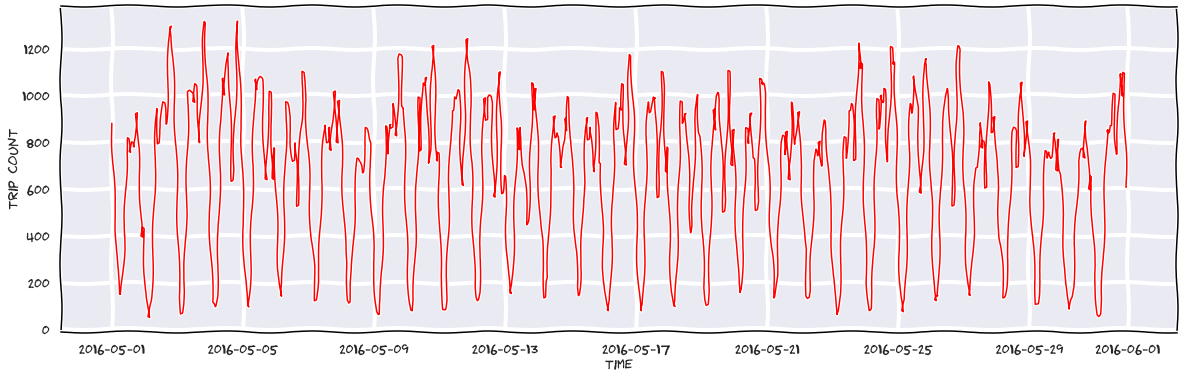

In [93]:
ESN_reg=1231
ESB_ts = time_series_table[ESN_reg]
with plt.xkcd():
  plt.figure(figsize=(20,6))
  plt.plot(ESB_ts, color = 'red',linewidth = 1.5)
  plt.grid(True)
  plt.xlabel('time')
  plt.ylabel('trip count')